In [1]:
%reload_ext autoreload
%reload_ext autoreload

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
from functools import partial
# warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [4]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [5]:
sys.path.append("../")

In [6]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor
from chaosmining.simulation.functions import abs_argmax_topk
from chaosmining.utils import radar_factory

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [8]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

In [9]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

In [10]:
import inspect

In [11]:
def call_with_relevant_args(func, all_args):
    func_params = inspect.signature(func).parameters
    relevant_args = {key: all_args[key] for key in func_params if key in all_args}
    return func(**relevant_args)

In [483]:
save_flag = True

# Generate Functions and Data

In [128]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [129]:
formulas = read_formulas(formulas_path)

In [385]:
formula_id = 1
seed = 9999
test_size = 0.2
n_steps = 20

In [386]:
num_features, function = formulas[formula_id]

In [387]:
num_noises = 200
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 201) y true (10000, 1) y noise (10000, 1) intercepts 1 (10000,) derivatives 1 (10000,) integrations 1 (10000,)


In [388]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [389]:
y = y_true + y_noise

In [390]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [391]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [392]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [393]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [394]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=201, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [395]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [396]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0, disable=True)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)
    print('train loss:', running_loss)

In [397]:
train(model, train_loader, num_epochs, optimizer)

train loss: 1.2339278043782542e-07


In [398]:
y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

In [399]:
score = mean_absolute_error(y_pred, y_test)
print('Test mean absolute value is', score)

Test mean absolute value is 0.14387331954993351


# Memory and Time

In [400]:
explainers = ['sa', 'dl', 'ig', 'fa']

In [401]:
times_keeper = []
memory_keeper = []

In [402]:
if torch.cuda.is_available():
    for explainer in explainers:
        start_time = time.time()
        torch.cuda.reset_peak_memory_stats()

        if explainer == 'ig':
            xai = IntegratedGradients(model)
        elif explainer == 'sa':
            xai = Saliency(model)
        elif explainer == 'dl':
            xai = DeepLift(model)
        elif explainer == 'fa':
            xai = FeatureAblation(model)
        
        all_arguments = {'inputs':Tensor(X_test).to(device), 'n_steps':10}
        xai_attr_test = call_with_relevant_args(xai.attribute, all_arguments)

        max_memory_used = torch.cuda.max_memory_allocated()
        time_cost = time.time() - start_time

        memory_keeper.append(max_memory_used/10**6)
        times_keeper.append(time_cost*1000)

/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/geshi/captum/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [403]:
memory_keeper

[16.829952, 28.343296, 97.493504, 18.26048]

In [404]:
times_keeper

[17.57073402404785, 33.09822082519531, 164.3691062927246, 66.79654121398926]

# Consistency

In [405]:
avg_corrs = []

In [406]:
for explainer in explainers:
    if explainer == 'ig':
        xai = IntegratedGradients(model)
    elif explainer == 'sa':
        xai = Saliency(model)
    elif explainer == 'dl':
        xai = DeepLift(model)
    elif explainer == 'fa':
        xai = FeatureAblation(model)
    
    all_arguments = {'inputs':Tensor(X_test).to(device), 'n_steps':10}
    xai_attr_test = call_with_relevant_args(xai.attribute, all_arguments)
    abs_xai_attr_test = np.abs(xai_attr_test.detach().cpu().numpy())
    mean_abs_xai_attr_test = abs_xai_attr_test.mean(0)
    
    inds = np.argpartition(-abs_xai_attr_test, num_features, axis=-1)[:,:num_features]
    mean_inds = np.argpartition(-mean_abs_xai_attr_test, num_features, axis=-1)[:num_features]
    
    corrs = []
    for ind in inds:
        shared = set(mean_inds).intersection(set(ind))
        corrs.append(len(shared))
    avg_corrs.append(np.mean(corrs))

In [407]:
avg_corrs

[0.3605, 0.1905, 0.1925, 0.108]

# plots

In [408]:
memories = [
    [16.829952, 28.343296, 97.493504, 18.26048],
    [16.501248, 28.014592, 97.1648, 17.931776],
    [16.172544, 27.685888, 96.836096, 17.603072],
    [15.84384, 27.357184, 96.507392, 17.274368],
    [15.515136, 27.02848, 96.178688, 16.945664],
    [15.194624, 26.699776, 95.849984, 16.891904],
    [14.881792, 26.385408, 95.6416, 16.345088],
    [14.569984, 26.104832, 95.432704, 16.07168],
    [14.257664, 25.824768, 95.22432, 15.799808],
    [13.943808, 25.54368, 95.015936, 15.527424],
    [13.627904, 25.259008, 94.802944, 15.24992],
    [13.313024, 24.976384, 94.592512, 14.976],
    [12.99712, 24.691712, 95.422464, 15.702016],
    [12.680704, 24.408064, 95.129088, 15.329792],
    [11.643392, 22.35392, 92.514816, 13.276672],
]

In [409]:
times = [
    [17.57073402404785, 33.09822082519531, 164.3691062927246, 66.79654121398926],
    [17.444372177124023, 32.74846076965332, 164.60132598876953, 67.02136993408203],
    [17.5931453704834, 32.86170959472656, 165.26436805725098, 67.16442108154297],
    [17.406702041625977, 32.85098075866699, 164.99853134155273, 66.98465347290039],
    [17.89236068725586, 33.24103355407715, 164.55912590026855, 67.56782531738281],
    [17.357349395751953, 32.87506103515625, 165.3115749359131, 67.66724586486816],
    [17.124414443969727, 32.79280662536621, 262.2706890106201, 67.36636161804199],
    [17.31085777282715, 33.065080642700195, 258.2216262817383, 70.36113739013672],
    [17.3342227935791, 32.450199127197266, 163.5572910308838, 67.78836250305176],
    [17.511367797851562, 32.73153305053711, 257.0779323577881, 68.28618049621582],
    [16.77250862121582, 31.74304962158203, 159.18993949890137, 68.67241859436035],
    [16.808748245239258, 31.521081924438477, 159.9867343902588, 69.24891471862793],
    [16.715049743652344, 31.464099884033203, 159.44409370422363, 70.34039497375488],
    [16.75891876220703, 31.279802322387695, 158.73265266418457, 69.96011734008789],
    [30.460596084594727, 54.06546592712402, 248.71444702148438, 70.21117210388184],    
]

In [410]:
consistencies = [
    [0.3605, 0.1905, 0.1925, 0.108],
    [0.2295, 0.1465, 0.137, 0.0535],
    [0.859, 0.621, 0.6155, 0.4815],
    [1.0, 0.9575, 0.9785, 0.9575],
    [1.0, 0.944, 0.971, 0.943],
    [0.8545, 0.577, 0.5625, 0.426],
    [1.0185, 0.498, 0.7575, 0.3765],
    [1.119, 0.493, 0.769, 0.406],
    [2.371, 1.7035, 1.7415, 1.472],
    [2.5095, 1.5235, 1.7845, 1.428],
    [3.205, 2.03, 2.567, 1.927],
    [3.012, 1.948, 2.277, 1.842],
    [3.716, 2.688, 3.109, 2.4065],
    [4.396, 3.206, 3.8855, 3.1025],
    [4.399, 3.1845, 3.726, 2.9995],    
]

In [542]:
convergences = [
    [1, 1, 1, 1],
    [0.83, 0.88, 0.80, 0.89],
    [0.67, 0.63, 0.79, 0.76],
    [0.99, 0.98, 0.99, 0.99],
    [0.97, 0.97, 0.92, 0.94],
    [0.59, 0.61, 0.55, 0.59],
    [1.91, 1.89, 1.78, 1.79],
    [2.43, 2.48, 2.48, 2.42],
    [3.39, 3.44, 3.47, 2.91],
    [3.4, 3.43, 3.23, 3.13],
    [5.27, 5.38, 5.07, 5.11],
    [5.37, 5.24, 4.97, 5.80],
    [6.29, 6.38, 6.06, 5.69],
    [7.1, 7.2, 6.77, 7.05],
    [8.46, 8.05, 8.16, 7.61],  
]

# Plots

In [484]:
xai_names = ['SA', 'DL', 'IG', 'FA']
colors = ['m', 'g', 'b', 'k']

In [518]:
def error_bar_plot(names, values, colors, ylabel, errors=None):
    # Define the positions of the bars
    x_pos = np.arange(len(names))
    
    # Create the bar plot
    fig, ax = plt.subplots(layout='constrained')
    if errors is not None:
        bars = ax.bar(x_pos, values, yerr=errors, capsize=5, color=colors, edgecolor='black', alpha=0.4, 
        	error_kw={'ecolor': 'black', 'elinewidth': 2, 'capsize': 12})
    else:
        bars = ax.bar(x_pos, values, color=colors, edgecolor='black', alpha=0.4, 
        	error_kw={'ecolor': 'black', 'elinewidth': 2, 'capsize': 12})
    
    # Set the labels for the x-ticks
    # ax.set_ylim(0.0, 1.0)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add labels and title
    ax.set_ylabel(ylabel, fontsize=16)
    
    # Display the plot
    # plt.show()

## memory cost

In [519]:
memories_cost = np.array(memories)
# memories_cost /= memories_cost[:,:1]
values = memories_cost.mean(0)
errors = memories_cost.std(0)

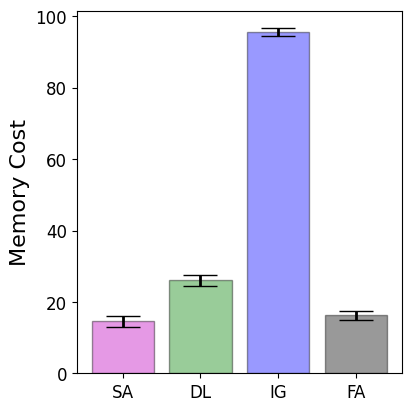

In [520]:
error_bar_plot(xai_names, values, colors, 'Memory Cost', errors)
if save_flag:
    plt.savefig('../memory.png', dpi=300, bbox_inches='tight')

## time cost

In [521]:
times_cost = np.array(times)
# times_cost /= times_cost[:,:1]
values = times_cost.mean(0)
errors = times_cost.std(0)

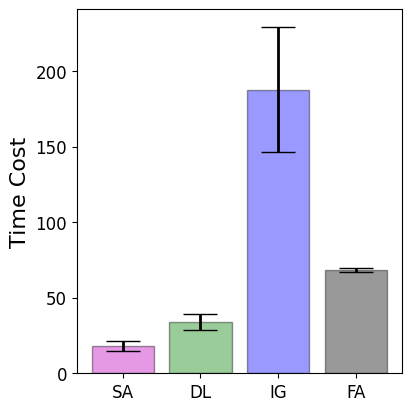

In [522]:
error_bar_plot(xai_names, values, colors, 'Time Cost', errors)
if save_flag:
    plt.savefig('../time.png', dpi=300, bbox_inches='tight')

## Consistencies

In [540]:
consistencies_array = np.array(consistencies)
consistencies_array /= consistencies_array[:,:1]
values = consistencies_array.mean(0)
# errors = consistencies_array.std(0)

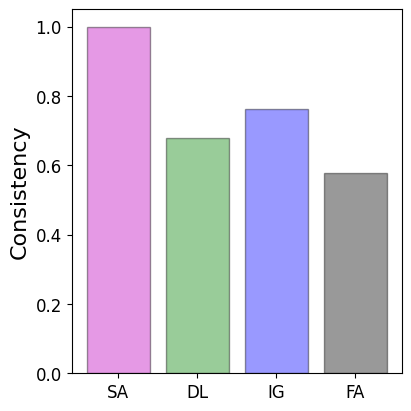

In [541]:
error_bar_plot(xai_names, values, colors, 'Consistency')
if save_flag:
    plt.savefig('../consistency.png', dpi=300, bbox_inches='tight')

# Convergences

In [543]:
convergences_array = np.array(convergences)
convergences_array /= convergences_array[:,:1]
values = convergences_array.mean(0)
# errors = convergences_array.std(0)

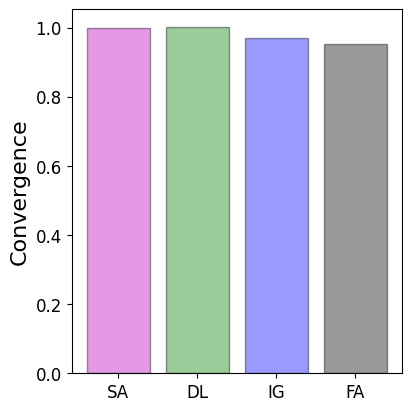

In [544]:
error_bar_plot(xai_names, values, colors, 'Convergence')
if save_flag:
    plt.savefig('../convergence.png', dpi=300, bbox_inches='tight')